Loading the results data...
Loaded data for 50 regions

=== Starting Comprehensive Analysis Pipeline ===

1. Analyzing overall profit by trip length...

Summary statistics by trip length:
                     avg_profit                            profit_per_mile  \
                           mean median   std    min    max            mean   
trip_length_category                                                         
very_short                12.54  12.22  1.80   9.27  21.44           11.59   
short                     22.65  22.58  1.11  20.02  25.26            7.38   
medium                    38.68  38.20  2.45  35.03  47.26            5.65   
long                      67.25  67.75  3.63  60.56  75.70            4.77   
very_long                 77.61  79.63  7.28  44.80  86.01            2.83   

                                               trip_count  
                     median   std   min    max        sum  
trip_length_category                                       
very_sh

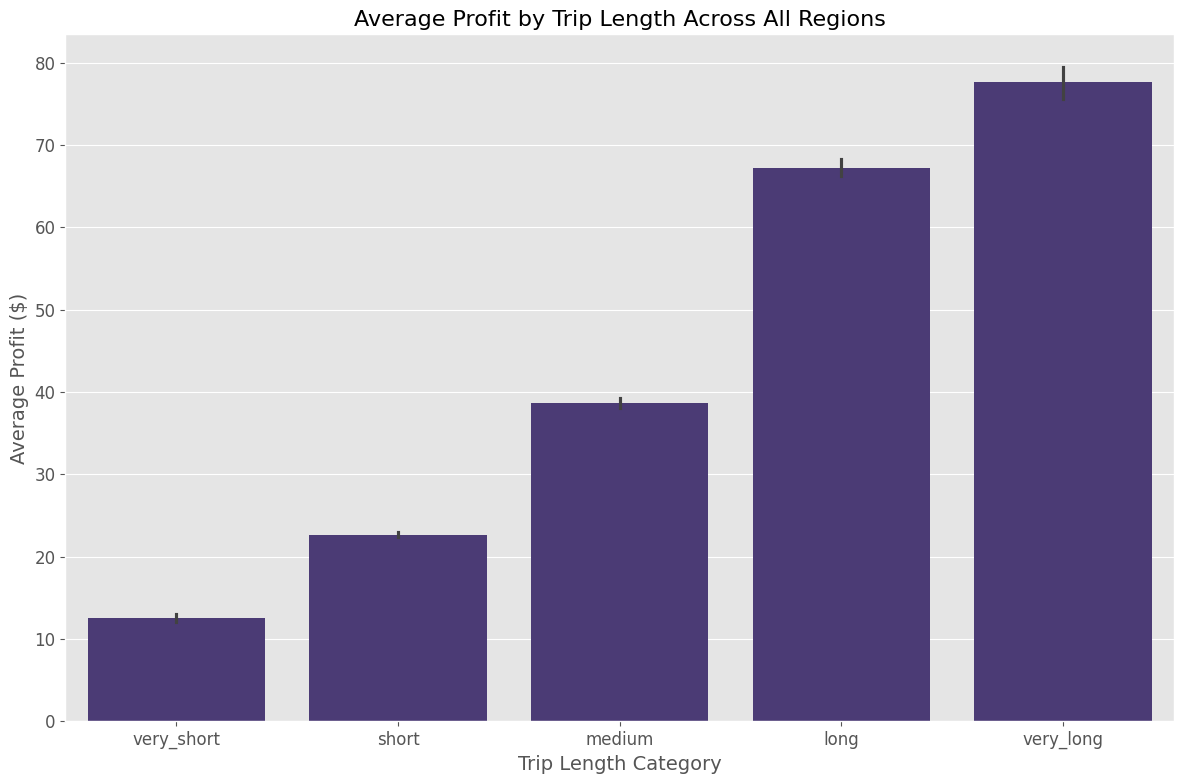

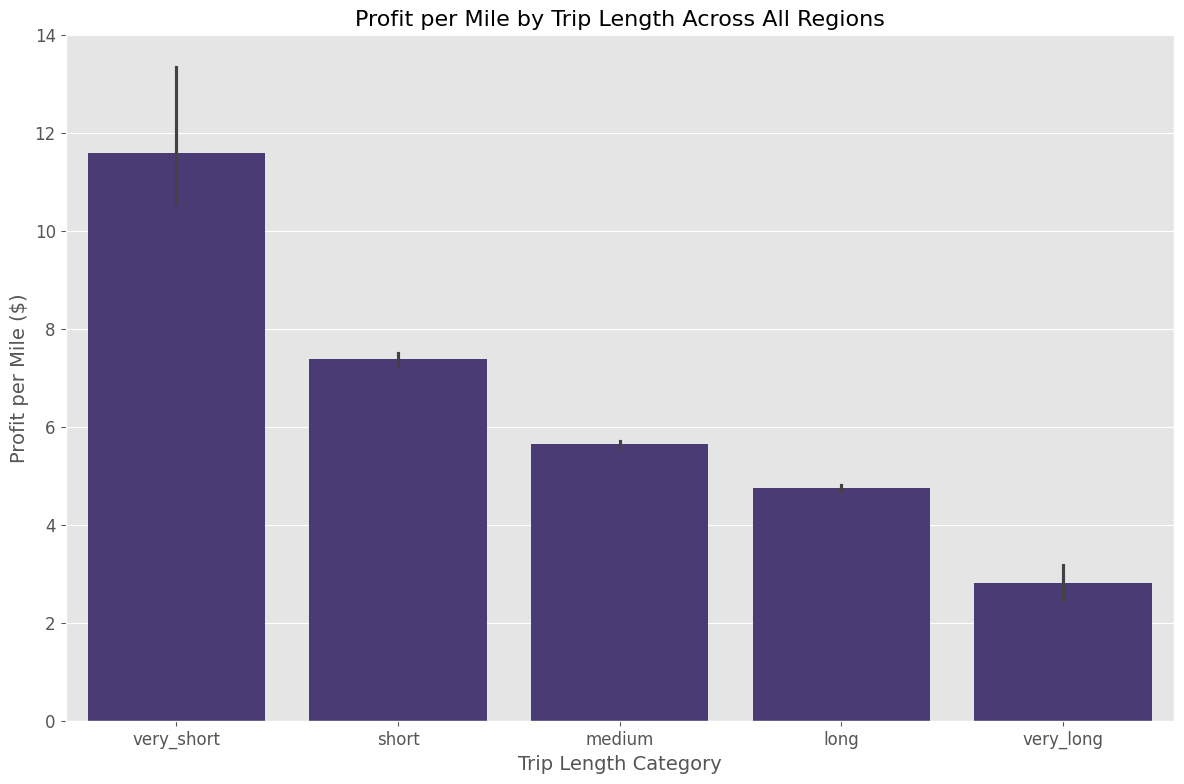

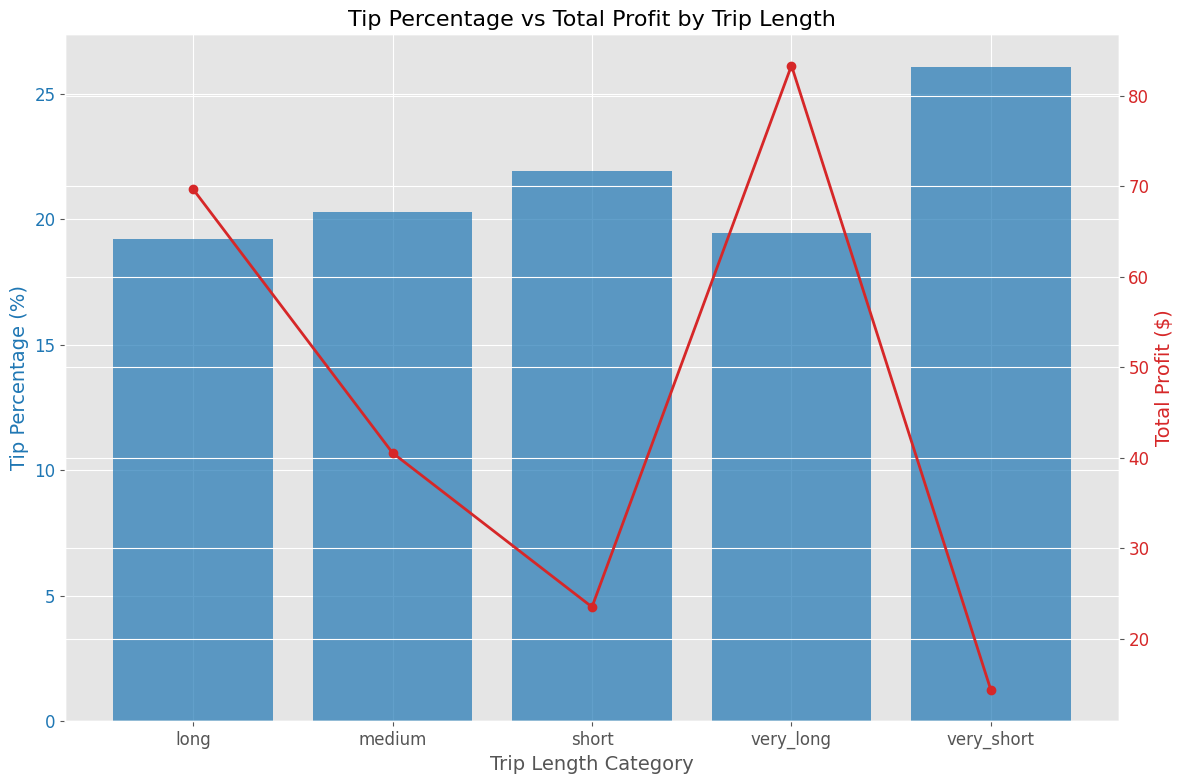

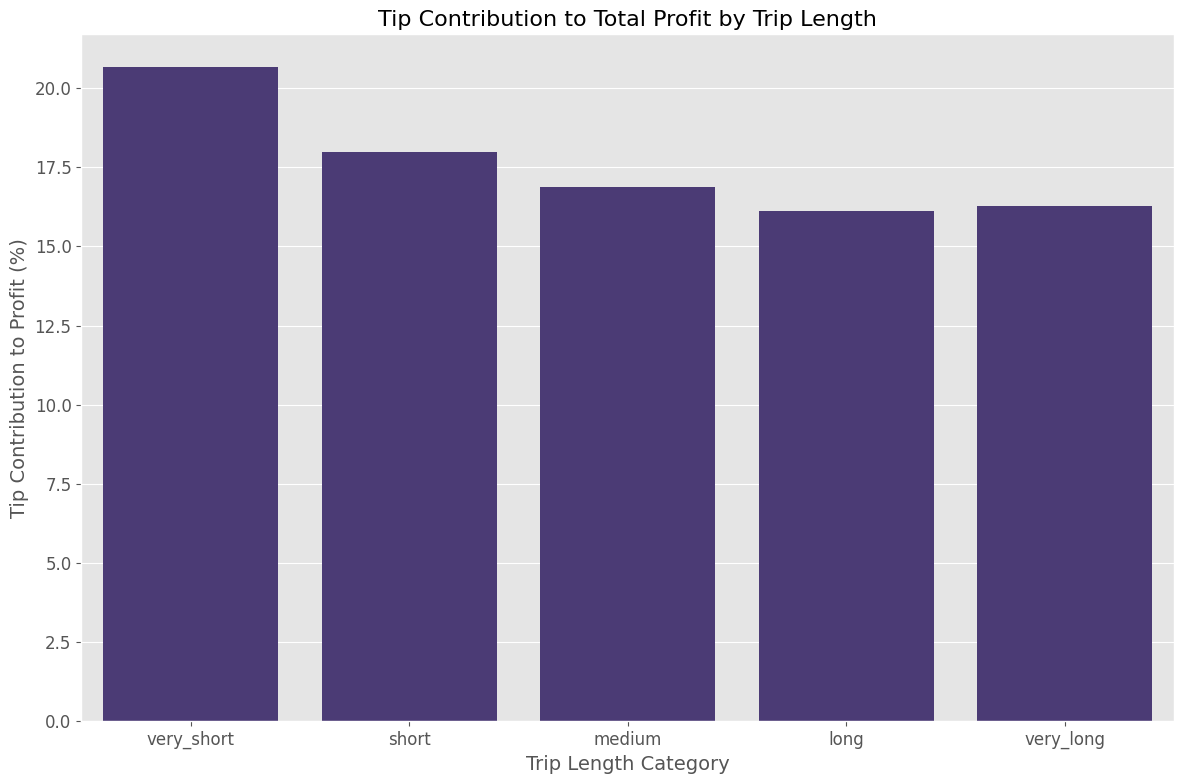

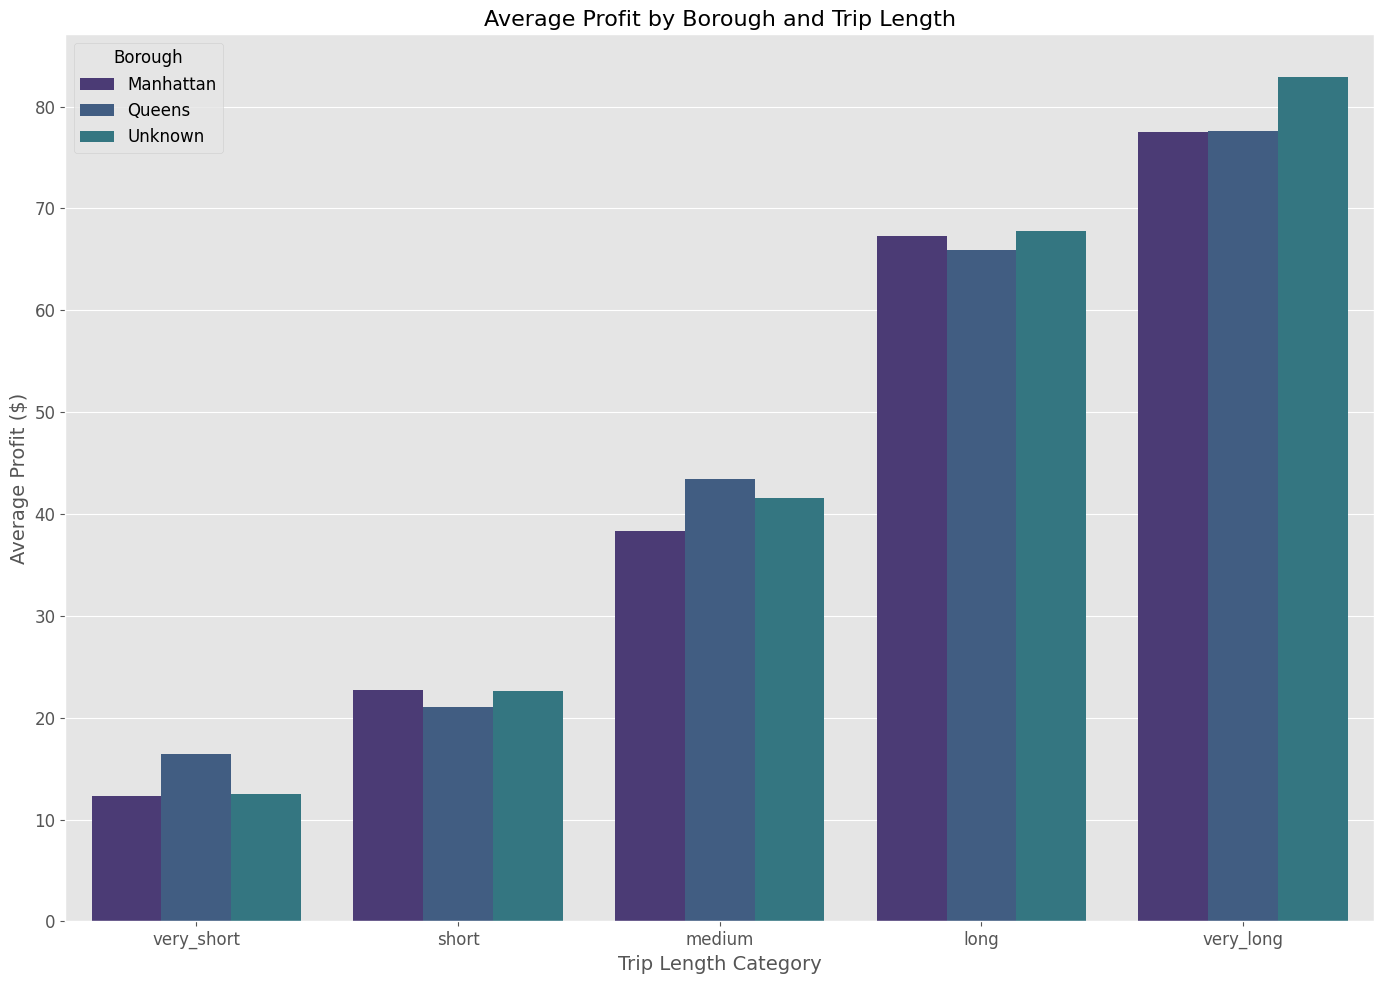

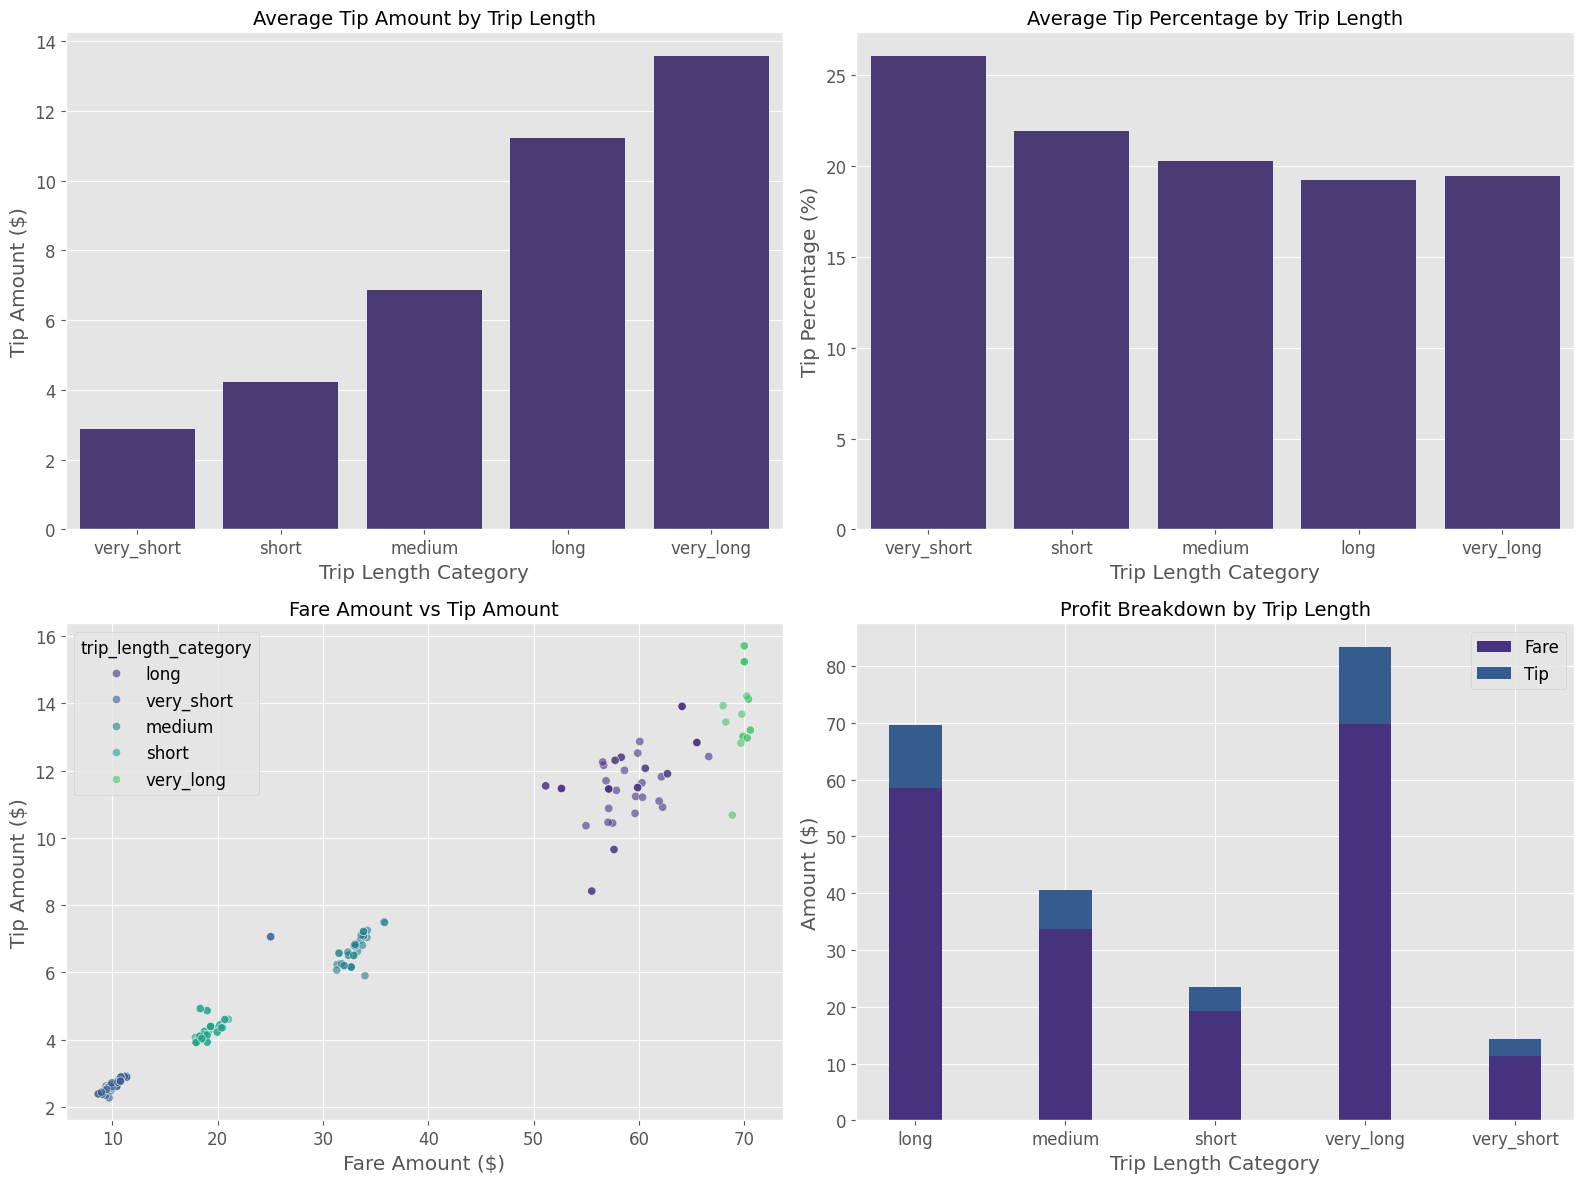

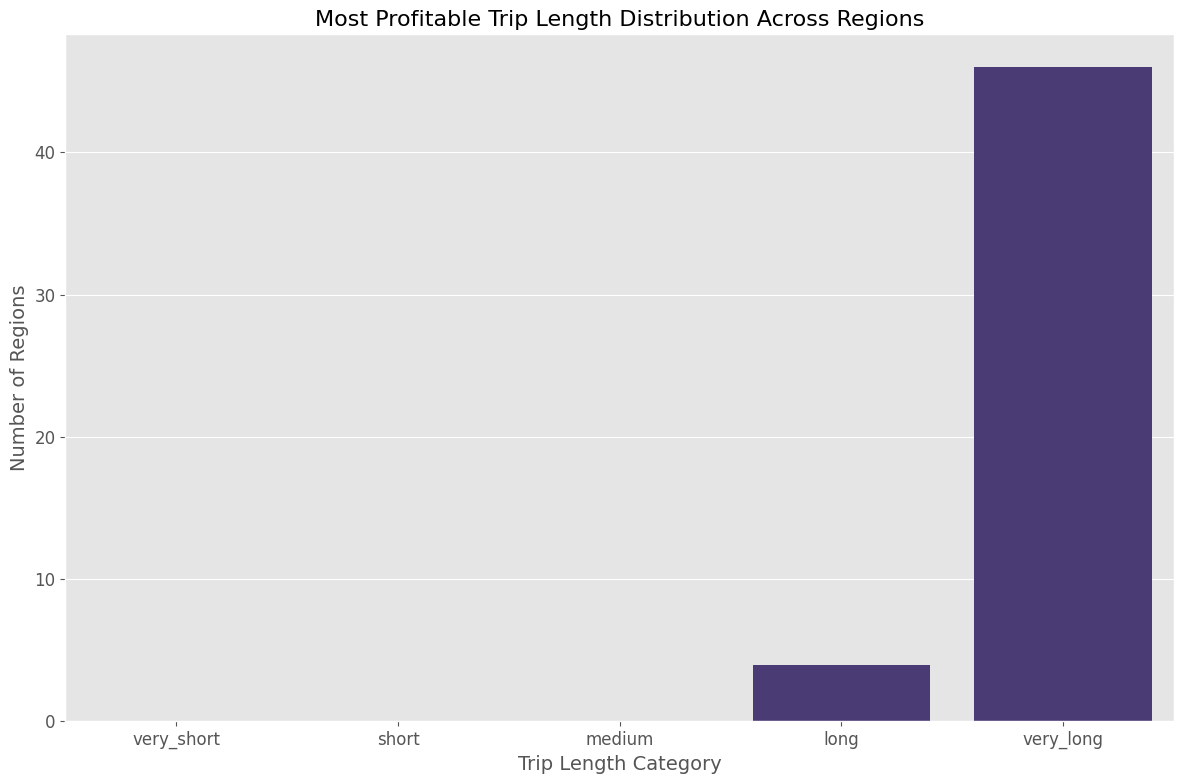

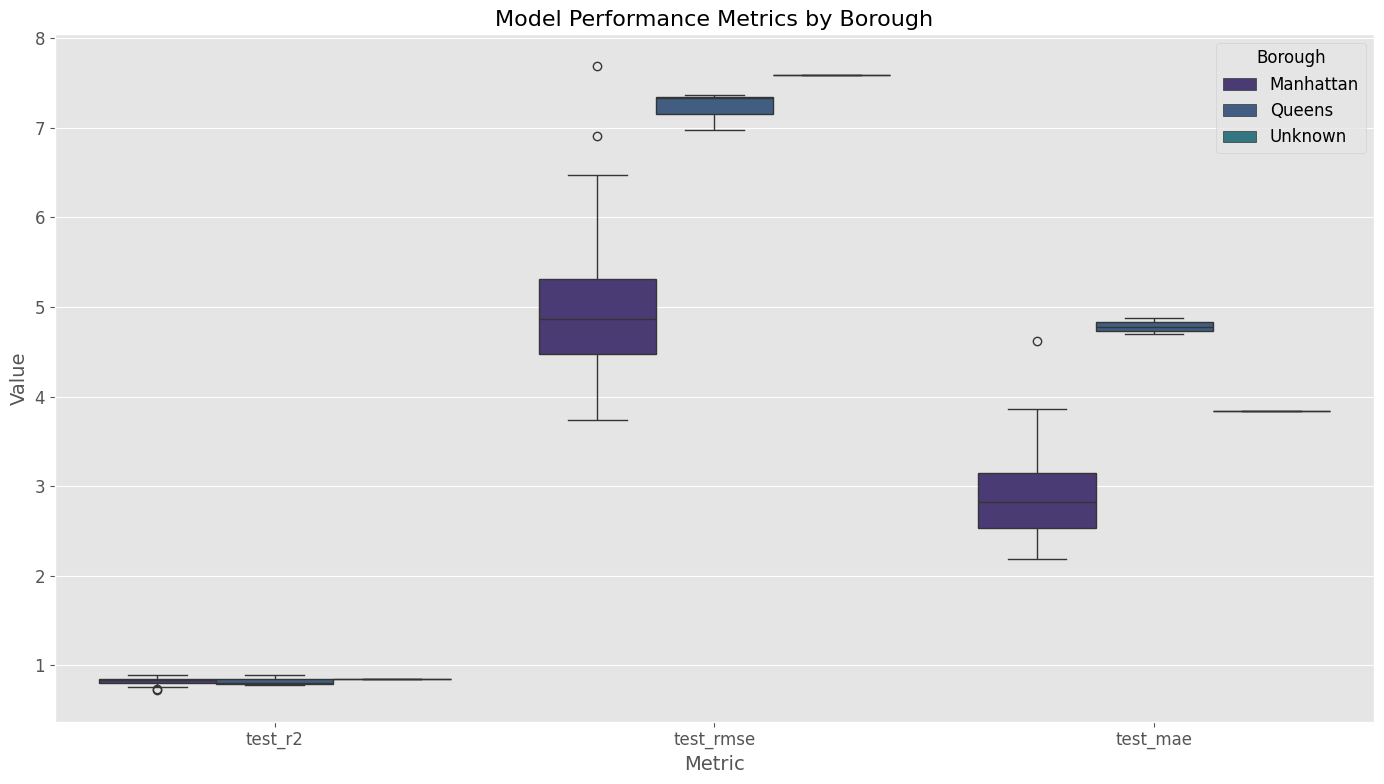


10. Creating profit profiles for cross-regional comparison...

Number of regions dominated by each trip length category:
dominant_category
very_long    45
long          4
Name: count, dtype: int64

Number of regions with balanced profit distribution (no category > 50%): 49

11. Integrating tipping patterns with regional profit profiles...

Number of regions where each trip length is optimal (considering both profit and tips):
optimal_trip_length
long         36
very_long    14
Name: count, dtype: int64

Comparing optimal trip lengths (including tips) vs. most profitable trip lengths:
           by_profit_only  by_profit_and_tips
long                    4                  36
very_long              46                  14

12. Examining correlation between model performance and profitability...

Correlation between model metrics and region profitability:
                    test_r2  test_rmse  test_mae  avg_region_profit
test_r2            1.000000  -0.406841 -0.321620           0.192379

In [35]:
# Import necessary libraries
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load the data
print("Loading the results data...")
results = joblib.load('app_data/all_results.joblib')
print(f"Loaded data for {len(results)} regions")

# Define helper functions for analysis
def aggregate_profit_by_trip_length():
    """Aggregate profit metrics across all regions by trip length category"""
    all_data = []
    
    for region_id, region_data in results.items():
        if 'profit_analysis' in region_data:
            profit_df = region_data['profit_analysis'].copy()
            profit_df['region_id'] = region_id
            profit_df['borough'] = region_data['borough']
            profit_df['zone_name'] = region_data['zone_name']
            all_data.append(profit_df)
    
    return pd.concat(all_data, ignore_index=True)

def aggregate_payment_by_trip_length():
    """Aggregate payment data across all regions by trip length and payment type"""
    all_data = []
    
    for region_id, region_data in results.items():
        if 'payment_analysis' in region_data:
            payment_df = region_data['payment_analysis'].copy()
            payment_df['region_id'] = region_id
            payment_df['borough'] = region_data['borough']
            payment_df['zone_name'] = region_data['zone_name']
            all_data.append(payment_df)
    
    return pd.concat(all_data, ignore_index=True)

def get_top_regions_by_profit():
    """Get top regions by overall profit"""
    region_profits = []
    
    for region_id, region_data in results.items():
        if 'profit_analysis' in region_data:
            avg_profit = region_data['profit_analysis']['avg_profit'].mean()
            region_profits.append({
                'region_id': region_id,
                'borough': region_data['borough'],
                'zone_name': region_data['zone_name'],
                'avg_profit': avg_profit
            })
    
    return pd.DataFrame(region_profits).sort_values('avg_profit', ascending=False)

def analyze_tipping_patterns():
    """Analyze tipping patterns across regions and trip lengths"""
    all_tips = []
    
    for region_id, region_data in results.items():
        if 'payment_analysis' in region_data:
            payment_df = region_data['payment_analysis'].copy()
            
            # Focus on credit card payments which have tips
            cc_data = payment_df[payment_df['payment_type_desc'] == 'Credit Card'].copy()
            
            if not cc_data.empty:
                for _, row in cc_data.iterrows():
                    all_tips.append({
                        'region_id': region_id,
                        'borough': region_data['borough'],
                        'zone_name': region_data['zone_name'],
                        'trip_length_category': row['trip_length_category'],
                        'fare_amount': row['fare_amount'],
                        'tip_amount': row['tip_amount'],
                        'total_profit': row['total_profit'],
                        'tip_percentage': (row['tip_amount'] / row['fare_amount'] * 100) if row['fare_amount'] > 0 else 0,
                        'trip_count': row['trip_count']
                    })
    
    tips_df = pd.DataFrame(all_tips)
    return tips_df

def analyze_region_trip_profitability():
    """Analyze profitability by region and trip length"""
    region_trips = []
    
    for region_id, region_data in results.items():
        if 'profit_analysis' in region_data:
            profit_df = region_data['profit_analysis'].copy()
            
            # Add region info
            for _, row in profit_df.iterrows():
                region_trips.append({
                    'region_id': region_id,
                    'borough': region_data['borough'],
                    'zone_name': region_data['zone_name'],
                    'trip_length_category': row['trip_length_category'],
                    'avg_profit': row['avg_profit'],
                    'profit_per_mile': row['profit_per_mile'],
                    'trip_count': row['trip_count']
                })
    
    return pd.DataFrame(region_trips)

def collect_model_metrics():
    """Collect model performance metrics from all regions"""
    all_metrics = []
    
    for region_id, region_data in results.items():
        if 'metrics' in region_data:
            metrics = region_data['metrics'].copy()
            metrics_dict = {
                'region_id': str(region_id),  # Convert to string
                'borough': str(region_data['borough']),
                'zone_name': str(region_data['zone_name']),
                'test_mse': float(metrics.get('test_mse', np.nan)),
                'test_rmse': float(metrics.get('test_rmse', np.nan)),
                'test_mae': float(metrics.get('test_mae', np.nan)),
                'test_r2': float(metrics.get('test_r2', np.nan)),
                'test_evs': float(metrics.get('test_evs', np.nan)),
                'cv_r2': float(metrics.get('cv_r2', np.nan))
            }
            all_metrics.append(metrics_dict)
    
    return pd.DataFrame(all_metrics)

# Begin analysis pipeline
print("\n=== Starting Comprehensive Analysis Pipeline ===\n")

# 1. Overall profit analysis by trip length across all regions
print("1. Analyzing overall profit by trip length...")
all_profits = aggregate_profit_by_trip_length()

# Summary statistics by trip length
trip_length_summary = all_profits.groupby('trip_length_category').agg({
    'avg_profit': ['mean', 'median', 'std', 'min', 'max'],
    'profit_per_mile': ['mean', 'median', 'std', 'min', 'max'],
    'trip_count': 'sum'
}).round(2)

print("\nSummary statistics by trip length:")
print(trip_length_summary)

# 2. Payment and tipping analysis
print("\n2. Analyzing payment and tipping patterns...")
all_payments = aggregate_payment_by_trip_length()
tipping_data = analyze_tipping_patterns()

# Tipping summary by trip length
tip_summary = tipping_data.groupby('trip_length_category').agg({
    'tip_amount': ['mean', 'median', 'std'],
    'tip_percentage': ['mean', 'median', 'std'],
    'total_profit': ['mean', 'median', 'std'],
    'trip_count': 'sum'
}).round(2)

print("\nTipping summary by trip length:")
print(tip_summary)

# 3. Borough-level analysis
print("\n3. Analyzing profits by borough...")
borough_profits = all_profits.groupby(['borough', 'trip_length_category']).agg({
    'avg_profit': 'mean',
    'profit_per_mile': 'mean',
    'trip_count': 'sum'
}).reset_index()

# 4. Advanced tipping analysis
print("\n4. Performing advanced tipping analysis...")
# Calculate correlation between trip length, fare amount, and tips
fare_tip_correlation = tipping_data.groupby('trip_length_category').apply(
    lambda x: x[['fare_amount', 'tip_amount', 'tip_percentage']].corr()
).round(3)

print("\nCorrelation between fare amount and tip amount by trip length:")
print(fare_tip_correlation)

# Tip percentage by trip length
tip_pct_by_length = tipping_data.groupby('trip_length_category').agg({
    'tip_percentage': 'mean',
    'total_profit': 'mean',
    'fare_amount': 'mean',
    'tip_amount': 'mean',
    'trip_count': 'sum'
}).reset_index()

print("\nTip percentage by trip length:")
print(tip_pct_by_length)

# 5. Most profitable regions
print("\n5. Identifying most profitable regions...")
top_regions = get_top_regions_by_profit().head(10)
print("\nTop 10 most profitable regions overall:")
print(top_regions)

# 6. Analyzing tip contribution to profit
print("\n6. Analyzing tip contribution to total profit...")
tipping_data['tip_profit_ratio'] = tipping_data['tip_amount'] / tipping_data['total_profit'] * 100

tip_contribution = tipping_data.groupby('trip_length_category').agg({
    'tip_profit_ratio': ['mean', 'median', 'std'],
    'tip_amount': 'mean',
    'total_profit': 'mean'
}).round(2)

print("\nTip contribution to total profit by trip length:")
print(tip_contribution)

# 7. Region-specific trip length profitability
print("\n7. Analyzing region-specific trip length profitability...")
region_trip_data = analyze_region_trip_profitability()

# Find the most profitable trip length for each region
most_profitable_trips = region_trip_data.sort_values('avg_profit', ascending=False).drop_duplicates(['region_id'])
region_profit_distribution = region_trip_data.groupby('region_id').apply(
    lambda x: pd.Series({
        f"{cat}_profit": x[x['trip_length_category'] == cat]['avg_profit'].values[0] if cat in x['trip_length_category'].values else 0
        for cat in ['very_short', 'short', 'medium', 'long', 'very_long']
    })
)

# Count how many regions have each trip length as most profitable
best_length_counts = most_profitable_trips['trip_length_category'].value_counts()
print("\nNumber of regions where each trip length is most profitable:")
print(best_length_counts)

# 8. Model performance metrics analysis
print("\n8. Analyzing model performance metrics...")
model_metrics = collect_model_metrics()

numeric_columns = ['test_mse', 'test_rmse', 'test_mae', 'test_r2', 'test_evs', 'cv_r2']
avg_metrics = model_metrics[numeric_columns].mean().round(4)
print("\nAverage model performance metrics across all regions:")
print(avg_metrics)

# Calculate best and worst performing regions
best_r2_region = model_metrics.loc[model_metrics['test_r2'].idxmax()]
worst_r2_region = model_metrics.loc[model_metrics['test_r2'].idxmin()]

print(f"\nBest performing region by R² score: {best_r2_region['zone_name']} ({best_r2_region['borough']}) - R² = {best_r2_region['test_r2']:.4f}")
print(f"Worst performing region by R² score: {worst_r2_region['zone_name']} ({worst_r2_region['borough']}) - R² = {worst_r2_region['test_r2']:.4f}")

# 9. Visualizations for insights
print("\n9. Creating visualizations for key insights...")

# 9.1 Plot average profit by trip length
plt.figure(figsize=(12, 8))
sns.barplot(x='trip_length_category', y='avg_profit', data=all_profits, 
            order=['very_short', 'short', 'medium', 'long', 'very_long'])
plt.title('Average Profit by Trip Length Across All Regions', fontsize=16)
plt.xlabel('Trip Length Category', fontsize=14)
plt.ylabel('Average Profit ($)', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 9.2 Plot profit per mile by trip length
plt.figure(figsize=(12, 8))
sns.barplot(x='trip_length_category', y='profit_per_mile', data=all_profits,
            order=['very_short', 'short', 'medium', 'long', 'very_long'])
plt.title('Profit per Mile by Trip Length Across All Regions', fontsize=16)
plt.xlabel('Trip Length Category', fontsize=14)
plt.ylabel('Profit per Mile ($)', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 9.3 Plot tip percentage and total profit by trip length
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Trip Length Category', fontsize=14)
ax1.set_ylabel('Tip Percentage (%)', fontsize=14, color=color)
bars = ax1.bar(tip_pct_by_length['trip_length_category'], tip_pct_by_length['tip_percentage'], 
         color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(tip_pct_by_length['trip_length_category'], rotation=0)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Profit ($)', fontsize=14, color=color)
line = ax2.plot(tip_pct_by_length['trip_length_category'], tip_pct_by_length['total_profit'], 
         marker='o', linestyle='-', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Tip Percentage vs Total Profit by Trip Length', fontsize=16)
plt.tight_layout()
plt.show()

# 9.4 Plot tip contribution to total profit
plt.figure(figsize=(12, 8))
tip_contribution_df = pd.DataFrame(tip_contribution['tip_profit_ratio']['mean'])
tip_contribution_df.columns = ['tip_profit_ratio']
tip_contribution_df.reset_index(inplace=True)

sns.barplot(x='trip_length_category', y='tip_profit_ratio', data=tip_contribution_df,
            order=['very_short', 'short', 'medium', 'long', 'very_long'])
plt.title('Tip Contribution to Total Profit by Trip Length', fontsize=16)
plt.xlabel('Trip Length Category', fontsize=14)
plt.ylabel('Tip Contribution to Profit (%)', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 9.5 Plot borough comparison by trip length
plt.figure(figsize=(14, 10))
sns.barplot(x='trip_length_category', y='avg_profit', hue='borough', data=borough_profits)
plt.title('Average Profit by Borough and Trip Length', fontsize=16)
plt.xlabel('Trip Length Category', fontsize=14)
plt.ylabel('Average Profit ($)', fontsize=14)
plt.legend(title='Borough', loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 9.6 Plot comprehensive tipping analysis
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, figure=fig)

# Top left: Tip amount by trip length
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(x='trip_length_category', y='tip_amount', data=tipping_data, 
            estimator=np.mean, ci=None, ax=ax1,
            order=['very_short', 'short', 'medium', 'long', 'very_long'])
ax1.set_title('Average Tip Amount by Trip Length', fontsize=14)
ax1.set_xlabel('Trip Length Category')
ax1.set_ylabel('Tip Amount ($)')

# Top right: Tip percentage by trip length
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(x='trip_length_category', y='tip_percentage', data=tipping_data, 
            estimator=np.mean, ci=None, ax=ax2,
            order=['very_short', 'short', 'medium', 'long', 'very_long'])
ax2.set_title('Average Tip Percentage by Trip Length', fontsize=14)
ax2.set_xlabel('Trip Length Category')
ax2.set_ylabel('Tip Percentage (%)')

# Bottom left: Scatter plot of fare vs tip
ax3 = fig.add_subplot(gs[1, 0])
sample_size = min(500, len(tipping_data))  # Take a smaller sample or all rows if fewer than 500
sns.scatterplot(x='fare_amount', y='tip_amount', hue='trip_length_category', 
                data=tipping_data.sample(n=sample_size, replace=True, random_state=42), 
                ax=ax3, alpha=0.6)
ax3.set_title('Fare Amount vs Tip Amount', fontsize=14)
ax3.set_xlabel('Fare Amount ($)')
ax3.set_ylabel('Tip Amount ($)')

# Bottom right: Profit breakdown (tip vs fare)
ax4 = fig.add_subplot(gs[1, 1])
tip_contribution_data = tipping_data.groupby('trip_length_category').agg({
    'tip_amount': 'mean',
    'fare_amount': 'mean'
}).reset_index()

width = 0.35
x = np.arange(len(tip_contribution_data))
ax4.bar(x, tip_contribution_data['fare_amount'], width, label='Fare')
ax4.bar(x, tip_contribution_data['tip_amount'], width, bottom=tip_contribution_data['fare_amount'], label='Tip')
ax4.set_title('Profit Breakdown by Trip Length', fontsize=14)
ax4.set_xlabel('Trip Length Category')
ax4.set_ylabel('Amount ($)')
ax4.set_xticks(x)
ax4.set_xticklabels(tip_contribution_data['trip_length_category'])
ax4.legend()

plt.tight_layout()
plt.show()

# 9.7 Plot most profitable trip length distribution across regions
plt.figure(figsize=(12, 8))
sns.countplot(x='trip_length_category', data=most_profitable_trips, 
              order=['very_short', 'short', 'medium', 'long', 'very_long'])
plt.title('Most Profitable Trip Length Distribution Across Regions', fontsize=16)
plt.xlabel('Trip Length Category', fontsize=14)
plt.ylabel('Number of Regions', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 9.8 Plot model performance metrics distribution
plt.figure(figsize=(14, 8))
metrics_to_plot = ['test_r2', 'test_rmse', 'test_mae']
metrics_df_melted = pd.melt(model_metrics, id_vars=['region_id', 'borough'], 
                            value_vars=metrics_to_plot,
                            var_name='metric', value_name='value')

sns.boxplot(x='metric', y='value', hue='borough', data=metrics_df_melted)
plt.title('Model Performance Metrics by Borough', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(title='Borough')
plt.tight_layout()
plt.show()

# 10. Cross-regional analysis: Create a "profit profile" for each region
print("\n10. Creating profit profiles for cross-regional comparison...")
# Calculate the relative profit distribution across trip lengths for each region
region_profit_dist = region_trip_data.pivot_table(
    index=['region_id', 'borough', 'zone_name'], 
    columns='trip_length_category', 
    values='avg_profit',
    aggfunc='mean'
).reset_index()

# Calculate the percentage of profit from each trip length category
profit_cols = ['very_short', 'short', 'medium', 'long', 'very_long']
for col in profit_cols:
    if col not in region_profit_dist.columns:
        region_profit_dist[col] = 0  # Fill with zeros if category doesn't exist
        
region_profit_dist['total_profit'] = region_profit_dist[profit_cols].sum(axis=1)
for col in profit_cols:
    region_profit_dist[f'{col}_pct'] = region_profit_dist[col] / region_profit_dist['total_profit'] * 100

# Identify the dominant trip length category for each region
region_profit_dist['dominant_category'] = region_profit_dist[profit_cols].idxmax(axis=1)

# Count regions by dominant category
dominant_categories = region_profit_dist['dominant_category'].value_counts()
print("\nNumber of regions dominated by each trip length category:")
print(dominant_categories)

# Find regions with balanced profit across categories (no single category > 50%)
balanced_regions = region_profit_dist[(region_profit_dist[profit_cols].max(axis=1) / region_profit_dist['total_profit'] < 0.5)]
print(f"\nNumber of regions with balanced profit distribution (no category > 50%): {len(balanced_regions)}")

# 11. Integration of tipping data with regional profit profiles
print("\n11. Integrating tipping patterns with regional profit profiles...")

# Aggregate tipping data by region and trip length
region_tips = tipping_data.groupby(['region_id', 'trip_length_category']).agg({
    'tip_amount': 'mean',
    'tip_percentage': 'mean',
    'total_profit': 'mean',
    'tip_profit_ratio': 'mean'
}).reset_index()

# Create a function to find optimal trip length by region based on combined metrics
def find_optimal_trip_length(region_data, tip_data):
    """Find optimal trip length for each region based on both profit and tipping metrics"""
    optimal_trips = []
    
    for region_id in region_data['region_id'].unique():
        region_rows = region_data[region_data['region_id'] == region_id]
        tip_rows = tip_data[tip_data['region_id'] == region_id]
        
        if region_rows.empty or tip_rows.empty:
            continue
            
        # Merge data to include both profit and tip information
        merged = pd.merge(region_rows, tip_rows, on=['region_id', 'trip_length_category'], how='inner')
        
        if merged.empty:
            continue
            
        # Calculate a combined score: normalized profit + normalized tip contribution
        max_profit = merged['avg_profit'].max()
        max_tip_ratio = merged['tip_profit_ratio'].max()
        
        if max_profit > 0 and max_tip_ratio > 0:
            merged['profit_score'] = merged['avg_profit'] / max_profit
            merged['tip_score'] = merged['tip_profit_ratio'] / max_tip_ratio
            merged['combined_score'] = 0.7 * merged['profit_score'] + 0.3 * merged['tip_score']
            
            # Get the best trip length by combined score
            best_row = merged.loc[merged['combined_score'].idxmax()]
            
            optimal_trips.append({
                'region_id': region_id,
                'borough': best_row['borough'],
                'zone_name': best_row['zone_name'],
                'optimal_trip_length': best_row['trip_length_category'], 
                'combined_score': best_row['combined_score'],
                'avg_profit': best_row['avg_profit'],
                'tip_percentage': best_row['tip_percentage'],
                'tip_profit_ratio': best_row['tip_profit_ratio']
            })
    
    return pd.DataFrame(optimal_trips)

# Find optimal trip lengths considering both profit and tips
optimal_trips = find_optimal_trip_length(region_trip_data, region_tips)

# Count regions by optimal trip length
optimal_length_counts = optimal_trips['optimal_trip_length'].value_counts()
print("\nNumber of regions where each trip length is optimal (considering both profit and tips):")
print(optimal_length_counts)

# Compare with merely most profitable
print("\nComparing optimal trip lengths (including tips) vs. most profitable trip lengths:")
comparison_df = pd.DataFrame({
    'by_profit_only': best_length_counts,
    'by_profit_and_tips': optimal_length_counts
})
print(comparison_df)

# 12. Model performance metrics and correlation with profit
print("\n12. Examining correlation between model performance and profitability...")

# Calculate the correlation between model performance and profitability
region_avg_profit = region_trip_data.groupby('region_id')['avg_profit'].mean().reset_index()
region_avg_profit = region_avg_profit.rename(columns={'avg_profit': 'avg_region_profit'})

# Convert region_id to string in both DataFrames to ensure consistent types
model_metrics['region_id'] = model_metrics['region_id'].astype(str)
region_avg_profit['region_id'] = region_avg_profit['region_id'].astype(str)

metrics_profit = pd.merge(model_metrics, region_avg_profit, on='region_id', how='inner')

# Calculate correlation between model performance and profitability
metrics_profit_corr = metrics_profit[['test_r2', 'test_rmse', 'test_mae', 'avg_region_profit']].corr()
print("\nCorrelation between model metrics and region profitability:")
print(metrics_profit_corr)

# 13. Summary of key findings
print("\n=== KEY FINDINGS BASED ON TIPPING PATTERNS AND PROFITABILITY ACROSS REGIONS ===\n")

# Calculate most profitable trip length based on total profit including tips
most_profitable_length = tip_pct_by_length.loc[tip_pct_by_length['total_profit'].idxmax(), 'trip_length_category']
highest_tip_pct_length = tip_pct_by_length.loc[tip_pct_by_length['tip_percentage'].idxmax(), 'trip_length_category']
best_tip_contribution_length = tip_contribution_df.loc[tip_contribution_df['tip_profit_ratio'].idxmax(), 'trip_length_category']

print(f"1. Most profitable trip length category overall: {most_profitable_length}")
print(f"2. Trip length with highest tip percentage: {highest_tip_pct_length}")
print(f"3. Trip length where tips contribute most to profit: {best_tip_contribution_length}")

# Profit efficiency calculation (profit per mile with tips)
profit_efficiency = all_profits.groupby('trip_length_category').agg({
    'profit_per_mile': 'mean'
}).reset_index()
most_efficient_length = profit_efficiency.loc[profit_efficiency['profit_per_mile'].idxmax(), 'trip_length_category']

print(f"4. Most profit-efficient trip length (profit per mile): {most_efficient_length}")

# Most common optimal trip length across regions
most_common_optimal = optimal_length_counts.idxmax()
print(f"5. Most common optimal trip length across regions (considering both profit and tips): {most_common_optimal}")

# Calculate the correlation between tip percentage and total profit
tip_profit_corr = tipping_data.groupby('trip_length_category').apply(
    lambda x: x[['tip_percentage', 'total_profit']].corr().iloc[0, 1]
).reset_index()
tip_profit_corr.columns = ['trip_length_category', 'correlation']
strongest_correlation = tip_profit_corr.loc[tip_profit_corr['correlation'].abs().idxmax(), 'trip_length_category']

print(f"6. Trip length with strongest correlation between tip percentage and total profit: {strongest_correlation}")

# Borough with highest average tips
borough_tips = tipping_data.groupby('borough').agg({
    'tip_amount': 'mean',
    'tip_percentage': 'mean'
}).reset_index()
highest_tip_borough = borough_tips.loc[borough_tips['tip_percentage'].idxmax(), 'borough']

print(f"7. Borough with highest average tip percentage: {highest_tip_borough}")

# Calculate the weighted profitability score (considering tips, profit per mile, and trip frequency)
weighted_profit = tipping_data.groupby('trip_length_category').apply(
    lambda x: (x['tip_percentage'].mean() * 0.3) + 
              (x['total_profit'].mean() / x['fare_amount'].mean() * 0.4) + 
              (np.log10(x['trip_count'].sum()) * 0.3)  # Log scale for frequency
).reset_index()
weighted_profit.columns = ['trip_length_category', 'weighted_score']
best_overall_length = weighted_profit.loc[weighted_profit['weighted_score'].idxmax(), 'trip_length_category']

print(f"8. Best overall trip length category (weighted by tips, profit ratio, and frequency): {best_overall_length}")

# Model performance summary
print(f"\n9. Average model performance across regions: R² = {avg_metrics['test_r2']:.4f}, RMSE = {avg_metrics['test_rmse']:.4f}")

# Regional variation
print(f"10. Regional variation: {dominant_categories.idxmax()} trips dominate in {dominant_categories.max()} regions")

# Tip impact on profitability
average_tip_contribution = tip_contribution['tip_profit_ratio']['mean'].mean()
print(f"11. Tips contribute an average of {average_tip_contribution:.2f}% to total profit across all trip lengths")

# Regional profitability distribution
max_region_profit = top_regions['avg_profit'].max()
min_region_profit = get_top_regions_by_profit()['avg_profit'].min()
profit_range = max_region_profit - min_region_profit
print(f"12. Regional profit range: ${profit_range:.2f} (from ${min_region_profit:.2f} to ${max_region_profit:.2f})")

print("\n=== End of Analysis ===")